## 对上证指数数据集进行预测

In [35]:
from pandas import read_csv
import numpy as np
from torch.utils.data import DataLoader,Dataset
import torch
from torchvision import transforms
import argparse
import torch
import pandas as pd

In [36]:
from torch.autograd import Variable
import torch.nn as nn
import torch

## 数据集说明

id：每条数据的唯一标识符，一般用于数据库中。

ts_code：股票代码，例如：600000.SH。

trade_date：交易日期，格式为年月日，例如：20210101。

close：收盘价，在当天交易结束后的最后一笔成交价为收盘价。

open：开盘价，在当天交易开始前的第一笔成交价为开盘价。

high：最高价，在当天交易过程中的最高成交价为最高价。

low：最低价，在当天交易过程中的最低成交价为最低价。

pre_close：昨收价，即上一个交易日的收盘价。

change：涨跌额，即当天收盘价与昨收价的差值。

pct_chg：涨跌幅，即涨跌额与昨收价的比值。

vol：成交量，即当天股票的成交量。

amount：成交金额，即当天股票的成交金额。

In [37]:
data = pd.read_csv('./data/000001SH_index.csv')

In [39]:
data.describe

<bound method NDFrame.describe of         id    ts_code  trade_date      close       open       high        low  \
0        0  000001.SH    19980105  1220.4730  1200.9480  1220.4950  1200.2220   
1        1  000001.SH    19980106  1233.6200  1223.7300  1233.6350  1215.4090   
2        2  000001.SH    19980107  1244.0700  1233.9560  1244.0980  1231.1460   
3        3  000001.SH    19980108  1237.1640  1243.1210  1250.0050  1235.8850   
4        4  000001.SH    19980109  1239.9010  1233.7010  1244.9990  1221.2970   
...    ...        ...         ...        ...        ...        ...        ...   
5425  5425  000001.SH    20200527  2836.8036  2847.3198  2848.9965  2831.9281   
5426  5426  000001.SH    20200528  2846.2217  2838.2072  2861.9241  2820.1455   
5427  5427  000001.SH    20200529  2852.3512  2835.5840  2855.3756  2829.6271   
5428  5428  000001.SH    20200601  2915.4311  2871.9641  2917.1508  2871.9641   
5429  5429  000001.SH    20200602  2921.3980  2916.3168  2926.3588  2909.12

In [16]:
data.head(3)

,id,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount
0,0,000001.SH,19980105,1220.473,1200.948,1220.495,1200.222,1194.102,26.371,2.2084,4371532.0,5363527.591
1,1,000001.SH,19980106,1233.620,1223.730,1233.635,1215.409,1220.473,13.147,1.0772,5148664.0,6196189.071
2,2,000001.SH,19980107,1244.070,1233.956,1244.098,1231.146,1233.620,10.450,0.8471,5756557.0,6276869.435


## 数据清洗与处理

In [17]:
def getData(corpusFile,sequence_length,batchSize):
    # 数据预处理 ，去除id、股票代码、前一天的收盘价、交易日期等对训练无用的无效数据
    stock_data = read_csv(corpusFile)
    stock_data.drop('ts_code', axis=1, inplace=True)  # 删除第二列’股票代码‘
    stock_data.drop('id', axis=1, inplace=True)  # 删除第一列’id‘
    stock_data.drop('pre_close', axis=1, inplace=True)  # 删除列’pre_close‘
    stock_data.drop('trade_date', axis=1, inplace=True)  # 删除列’trade_date‘

    close_max = stock_data['close'].max() #收盘价的最大值
    close_min = stock_data['close'].min() #收盘价的最小值
    df = stock_data.apply(lambda x: (x - min(x)) / (max(x) - min(x)))  # min-max标准化

    # 构造X和Y
    #根据前n天的数据，预测未来一天的收盘价(close)， 例如：根据1月1日、1月2日、1月3日、1月4日、1月5日的数据（每一天的数据包含8个特征），预测1月6日的收盘价。
    sequence = sequence_length
    X = []
    Y = []
    for i in range(df.shape[0] - sequence):
        X.append(np.array(df.iloc[i:(i + sequence), ].values, dtype=np.float32))
        Y.append(np.array(df.iloc[(i + sequence), 0], dtype=np.float32))

    # 构建batch
    total_len = len(Y)
    # print(total_len)

    trainx, trainy = X[:int(0.99 * total_len)], Y[:int(0.99 * total_len)]
    testx, testy = X[int(0.99 * total_len):], Y[int(0.99 * total_len):]
    train_loader = DataLoader(dataset=Mydataset(trainx, trainy, transform=transforms.ToTensor()), batch_size=batchSize,
                              shuffle=True)
    test_loader = DataLoader(dataset=Mydataset(testx, testy), batch_size=batchSize, shuffle=True)
    return close_max,close_min,train_loader,test_loader

In [18]:
class Mydataset(Dataset):
    def __init__(self, xx, yy, transform=None):
        self.x = xx
        self.y = yy
        self.tranform = transform

    def __getitem__(self, index):
        x1 = self.x[index]
        y1 = self.y[index]
        if self.tranform != None:
            return self.tranform(x1), y1
        return x1, y1

    def __len__(self):
        return len(self.x)

## 获取数据集

In [19]:
"""
close_max：是对数据进行预处理时计算出的数据集中的最大收盘价，用于归一化处理。
close_min：是对数据进行预处理时计算出的数据集中的最小收盘价，用于归一化处理。
train_loader：训练数据集的数据加载器。在这个变量中保存了预处理后的数据以及对应的标签，用于模型的训练。
test_loader：测试数据集的数据加载器。在这个变量中保存了预处理后的数据以及对应的标签，用于模型的测试。
"""
close_max, close_min, train_loader, test_loader = getData('./data/000001SH_index.csv',5,64)

In [20]:
close_max

6092.057

## 模型定义

In [21]:
import torch.nn as nn

In [22]:
class LSTM(nn.Module):
    def __init__(self, input_size=8, hidden_size=32, num_layers=1 , output_size=1 , dropout=0, batch_first=True):
        super(LSTM, self).__init__()
        # lstm的输入 #batch,seq_len, input_size
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.dropout = dropout
        self.batch_first = batch_first
        self.rnn = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=self.batch_first, dropout=self.dropout )
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        out, (hidden, cell) = self.rnn(x)  # x.shape : batch, seq_len, hidden_size , hn.shape and cn.shape : num_layes * direction_numbers, batch, hidden_size
        # a, b, c = hidden.shape
        # out = self.linear(hidden.reshape(a * b, c))
        out = self.linear(hidden)
        return out

In [23]:
model = LSTM(input_size=8, hidden_size=32, num_layers=2, output_size=1, dropout=0.1, batch_first=True)

In [24]:
model

LSTM(
  (rnn): LSTM(8, 32, num_layers=2, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
model.to(device)
criterion = nn.MSELoss()  # 定义损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Adam梯度下降  学习率=0.001

In [27]:
useGPU=True
epochs=100

In [28]:
from tensorboardX import SummaryWriter

In [29]:
# 指定保存日志的路径和名称
writer = SummaryWriter(log_dir='./logs')

In [30]:
# 指定保存日志的路径和名称
writer = SummaryWriter(log_dir='./logs')
for i in range(epochs):
    total_loss = 0
    for idx, (data, label) in enumerate(train_loader):
        if useGPU:
            data1 = data.squeeze(1).cuda()
            pred = model(Variable(data1).cuda())
            # print(pred.shape)
            pred = pred[1,:,:]
            label = label.unsqueeze(1).cuda()
            # print(label.shape)
        else:
            data1 = data.squeeze(1)
            pred = model(Variable(data1))
            pred = pred[1, :, :]
            label = label.unsqueeze(1)
        loss = criterion(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    mean_loss = total_loss / len(train_loader.dataset)
    writer.add_scalar('Train/Loss', mean_loss, i)
    print(total_loss)
    if i % 10 == 0:
        # torch.save(model, args.save_file)
        torch.save({'state_dict': model.state_dict()}, './weights/stock.pkl')
        print('第%d epoch，保存模型' % i)
writer.close()
# torch.save(model, args.save_file)
torch.save({'state_dict': model.state_dict()}, './weights/stock.pkl')

4.264938348904252
第0 epoch，保存模型
2.5260090436786413
1.9406768893823028
1.2259481749497354
0.4079762580804527
0.12787235097493976
0.09399733936879784
0.07398802228271961
0.06078803483978845
0.05111176654463634
0.04554363453644328
第10 epoch，保存模型
0.040365979861235246
0.03607269312487915
0.03409249914693646
0.03293465409660712
0.0326774290879257
0.031771152338478714
0.03065685798355844
0.03057541770976968
0.02923247797298245
0.02694336105196271
第20 epoch，保存模型
0.028182258232845925
0.027154730807524174
0.025503689015749842
0.024764513364061713
0.0263291912706336
0.02442920067551313
0.023875472179497592
0.023608551899087615
0.02317729702917859
0.022919043025467545
第30 epoch，保存模型
0.02285823901911499
0.02316198026528582
0.02215529268141836
0.022279893724771682
0.021756058406026568
0.02023555423511425
0.02039768738177372
0.02075960646470776
0.02007019642769592
0.018892707958002575
第40 epoch，保存模型
0.019287997492938302
0.019113545313302893
0.019009035677299835
0.01890098301373655
0.01855689181684283

## 预测

In [19]:
checkpoint = torch.load('./weights/stock.pkl')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [21]:
preds = []
labels = []

for idx, (x, label) in enumerate(test_loader):
    if useGPU:
        x = x.squeeze(1).cuda()  # batch_size,seq_len,input_size
    else:
        x = x.squeeze(1)
    pred = model(x)
    list = pred.data.squeeze(1).tolist()
    preds.extend(list[-1])
    labels.extend(label.tolist())
    
for i in range(len(preds)):
    print('预测值是%.2f,真实值是%.2f' % (
    preds[i][0] * (close_max - close_min) + close_min, labels[i] * (close_max - close_min) + close_min))

In [22]:
for i in range(len(preds)):
    print('预测值是%.2f,真实值是%.2f' % (
    preds[i][0] * (close_max - close_min) + close_min, labels[i] * (close_max - close_min) + close_min))

预测值是2814.84,真实值是2783.05
预测值是2830.82,真实值是2843.98
预测值是2891.89,真实值是2789.25
预测值是2828.39,真实值是2815.49
预测值是2888.65,真实值是2867.92
预测值是2823.69,真实值是2915.43
预测值是2790.15,真实值是2819.93
预测值是2969.56,真实值是2921.40
预测值是2805.61,真实值是2836.80
预测值是2881.07,真实值是2895.34
预测值是2846.72,真实值是2898.58
预测值是2812.73,真实值是2852.35
预测值是2779.93,真实值是2747.21
预测值是2877.08,真实值是2883.74
预测值是2847.56,真实值是2813.77
预测值是2889.60,真实值是2875.42
预测值是2829.56,真实值是2702.13
预测值是2770.23,真实值是2780.64
预测值是2812.18,真实值是2838.49
预测值是2807.12,真实值是2763.99
预测值是2735.05,真实值是2781.59
预测值是2794.92,真实值是2750.30
预测值是2817.47,真实值是2817.97
预测值是2903.45,真实值是2891.56
预测值是2855.76,真实值是2860.08
预测值是2804.07,真实值是2820.76
预测值是2830.68,真实值是2868.46
预测值是2822.67,真实值是2870.34
预测值是2779.22,真实值是2808.53
预测值是2837.60,真实值是2827.28
预测值是2949.92,真实值是2898.05
预测值是2846.81,真实值是2772.20
预测值是2845.77,真实值是2846.22
预测值是2957.04,真实值是2894.80
预测值是2863.34,真实值是2871.52
预测值是2808.17,真实值是2728.76
预测值是2785.33,真实值是2764.91
预测值是2812.87,真实值是2846.55
预测值是2879.06,真实值是2779.64
预测值是2823.33,真实值是2815.37
预测值是3066.72,真实值是2923.49
预测值是2798.99,真实值是

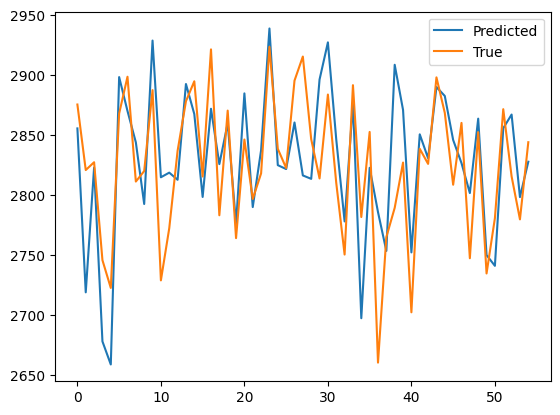

In [34]:
import matplotlib.pyplot as plt

predicted_values = [pred[0] * (close_max - close_min) + close_min for pred in preds]
true_values = [label * (close_max - close_min) + close_min for label in labels]

# 绘制折线图
plt.plot(range(len(predicted_values)), predicted_values, label='Predicted')
plt.plot(range(len(true_values)), true_values, label='True')
plt.legend()
plt.show()